In [112]:
import openai
import random
import json
import re
import numpy as np
import pandas as pd

from numpy import nan
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from nltk import WordNetLemmatizer
LEMMATIZER = WordNetLemmatizer()

In [3]:
import json

In [80]:
glove_path = 'data/glove.6B.300d.txt'
missing_verbs_path = 'data/missing_verbs_only_lemmatized.txt'
lexicon_path = 'FramesAgencyPower/agency_power.csv'

In [5]:
def load_glove(glove_file):
    """Load GloVe vectors in numpy array"""
    with open(glove_file, 'r') as f:
        model = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            model[word] = embedding
    return model

In [6]:
# find k examples from lexicon which are similar to given word (to be used as demonstrations to GPT);
# will use cosine similarity between glove embeddings
def find_k_similar_words(word: str, lexicon: dict, glove_embeddings: dict, k=5):
    if word in glove_embeddings:
        word_embedding = glove_embeddings[word]
        similarities = []
        for lexicon_word in lexicon:
            if lexicon_word in glove_embeddings:
                lexicon_word_embedding = glove_embeddings[lexicon_word]
                similarity = cosine_similarity([word_embedding], [lexicon_word_embedding])[0][0]
                similarities.append((lexicon_word, similarity))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return [x[0] for x in similarities[:k]]
    
    # if word not in glove embeddings, return k random words from lexicon
    else:
        return random.choices(list(lexicon.keys()), k=k)
    

In [174]:
def get_formatted_prompt_1(word: str, examples: list, lexicon: dict) -> str:
    examples_str = ''
    for example in examples:
        examples_str += "{'" + example + "': " + str(lexicon[example]) + '}\n'
    
    prompt = f"""I will give you a verb, and you will assign it two labels.
The first label represents the agency that the verb gives its grammatical subject. This label can be one of the following:
    "agency_pos": the verb gives its subject agency, 
    "agency_neg": the verb takes away agency from its subject,
    "agency_equal": the verb does not affect the agency of its subject.

The second label represents whether the verb gives power to its subject, object, or both. This label is only defined for transitive verbs. This label can be one of the following:
    "power_agent": the verb gives power to its subject,
    "power_theme": the verb gives power to its object,
    "power_equal": the verb does not affect the power of its subject or object, or it affects both equally.
    "nan": the verb is intransitive, so power is not defined.

Here are some examples of verbs and their labels:
{examples_str}
Now, please label the following verb: {word}

Format your answer as a JSON object in the same format as the examples above.

Answer: """

    return prompt


In [175]:
def get_formatted_prompt_2(word: str, examples: list, lexicon: dict) -> str:
    examples_str = ''
    for example in examples:
        example_labels = lexicon[example]
        examples_str += f"Verb: {example}\n"
        if example_labels['power'] is nan:
            examples_str += f"Sentence: I {example}\n"
        else:
            examples_str += f"Sentence: I {example} it\n"
        examples_str += f"Agency: {example_labels['agency']}\n"
        examples_str += f"Power: {example_labels['power']}\n\n"
    
    prompt = f"""I will give you a verb, and you will assign it two labels.
The first label represents the agency that the verb gives its grammatical subject. This label can be one of the following:
    "agency_pos": the verb gives its subject agency, 
    "agency_neg": the verb takes away agency from its subject,
    "agency_equal": the verb does not affect the agency of its subject.

The second label represents whether the verb gives power to its subject, object, or both. This label is only defined for transitive verbs. This label can be one of the following:
    "power_agent": the verb gives power to its subject,
    "power_theme": the verb gives power to its object,
    "power_equal": the verb does not affect the power of its subject or object, or it affects both equally.
    "nan": the verb is intransitive, so power is not defined.

Here are some examples of verbs and their labels. These will be in the context of the sentence "I [verb] it" if the verb is transitive or "I [verb]" if the verb is intransitive. 
{examples_str}
Now, please label the following verb in the same format as the above examples: 
Verb: {word}
"""

    return prompt


Have chatgpt classify which missing 'verbs' are actually verbs (because the spacy parser isn't totally accurate)

In [85]:
with open('data/missing_verbs.txt', 'r') as f:
    missing_verbs = f.read().splitlines()

In [122]:
len(missing_verbs)

2625

In [124]:
temperature = 0.0
p = 0.0
responses = {}
i = 688
    
while i < len(missing_verbs):
    responses = {}
    
    for verb in missing_verbs[i:]:
        print(i, end=' ')
        prompt = f'Can the word "{verb}" be used as a verb? Give a one word, yes or no answer.'
        
        try:
            response = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
                        n=1,
                        #temperature=temperature,
                        top_p=p,
                        messages=[
                            {"role": "user", "content": prompt}]
                        )
            responses[verb] = response.choices[0].message.content
            i += 1
        except:
            print('error')
            old_responses.update(responses)
            break
    

688 689 690 691 692 error
692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 error
744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 error
824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 93

In [126]:
len(responses)

25

In [91]:
#old_responses = responses

In [133]:
with open('data/missing_verbs_responses.json', 'w') as f:
    json.dump(old_responses, f, indent=4)

In [137]:
only_verbs = [verb for verb in old_responses if old_responses[verb] == 'Yes.']

In [139]:
LEMMATIZER.lemmatize('slapped', pos='v').lower()

'slap'

In [140]:
with open('data/missing_verbs_only.txt', 'w') as f:
    f.write('\n'.join(only_verbs))
with open('data/missing_verbs_only_lemmatized.txt', 'w') as f:
    f.write('\n'.join([LEMMATIZER.lemmatize(verb, pos='v').lower() for verb in only_verbs]))

Load the agency power lexicon

In [8]:
lexicon_df = pd.read_csv(lexicon_path)

# replace verb column with lemmas
lexicon_df['verb'] = lexicon_df['verb'].apply(lambda x: LEMMATIZER.lemmatize(x, pos='v').lower())

# conver to dict
lexicon = {}
for i, row in lexicon_df.iterrows():
    verb = row['verb']
    agency = row['agency']
    power = row['power']

    lexicon[verb] = {'agency': agency, 'power': power}

Load the verbs missing from the power agency lexicon

In [81]:
with open(missing_verbs_path, 'r') as f:
    missing_verbs = f.read().split('\n')

Load glove embeddings

In [9]:
glove_embeddings = load_glove(glove_path)

Have chatgpt label the missing verbs

In [82]:
missing_verb = missing_verbs[0]
examples = find_k_similar_words(missing_verb, lexicon, glove_embeddings, k=10)

In [84]:
missing_verb, examples

('rectify',
 ['straighten',
  'undo',
  'correct',
  'clarify',
  'solve',
  'fix',
  'resolve',
  'minimize',
  'improve',
  'revise'])

In [40]:
for example in examples:
    print( "{'" + example + "': " + str(lexicon[example]) + '}')

{'sentence': {'agency': 'agency_pos', 'power': 'power_agent'}}
{'jog': {'agency': 'agency_pos', 'power': nan}}
{'travel': {'agency': 'agency_pos', 'power': 'power_agent'}}
{'pardon': {'agency': 'agency_pos', 'power': 'power_agent'}}
{'stroll': {'agency': 'agency_equal', 'power': nan}}
{'terminate': {'agency': 'agency_pos', 'power': 'power_agent'}}
{'taxis': {'agency': 'agency_pos', 'power': nan}}
{'hike': {'agency': 'agency_equal', 'power': 'power_equal'}}
{'trip': {'agency': 'agency_pos', 'power': 'power_agent'}}
{'endure': {'agency': 'agency_neg', 'power': 'power_theme'}}


In [91]:
print(get_formatted_prompt(missing_verb, examples, lexicon))

I will give you a verb, and you will assign it two labels.
The first label represents the agency that the verb gives its grammatical subject. This label can be one of the following:
    "agency_pos": the verb gives its subject agency, 
    "agency_neg": the verb takes away agency from its subject,
    "agency_equal": the verb does not affect the agency of its subject.

The second label represents whether the verb gives power to its subject, object, or both. This label is only defined for transitive verbs. This label can be one of the following:
    "power_agent": the verb gives power to its subject,
    "power_theme": the verb gives power to its object,
    "power_equal": the verb does not affect the power of its subject or object, or it affects both equally.
    "nan": the verb is intransitive, so power is not defined.

Here are some examples of verbs and their labels. These will be in the context of the sentence "I [verb] you" if the verb is transitive or "I [verb]" if the verb is in

In [272]:
verb = 'exploit'
examples = find_k_similar_words(verb, train_dict, glove_embeddings, k=10)
prompt = get_formatted_prompt_2(verb, examples, train_dict)
print(prompt)

I will give you a verb, and you will assign it two labels.
The first label represents the agency that the verb gives its grammatical subject. This label can be one of the following:
    "agency_pos": the verb gives its subject agency, 
    "agency_neg": the verb takes away agency from its subject,
    "agency_equal": the verb does not affect the agency of its subject.

The second label represents whether the verb gives power to its subject, object, or both. This label is only defined for transitive verbs. This label can be one of the following:
    "power_agent": the verb gives power to its subject,
    "power_theme": the verb gives power to its object,
    "power_equal": the verb does not affect the power of its subject or object, or it affects both equally.
    "nan": the verb is intransitive, so power is not defined.

Here are some examples of verbs and their labels. These will be in the context of the sentence "I [verb] it" if the verb is transitive or "I [verb]" if the verb is int

Test chatgpt's accuracy on subset of the lexicon

In [10]:
train, test = train_test_split(lexicon_df, test_size=0.2, random_state=42)

In [11]:
train_dict = {}
test_dict = {}

for i, row in train.iterrows():
    verb = row['verb']
    agency = row['agency']
    power = row['power']

    train_dict[verb] = {'agency': agency, 'power': power}

for i, row in test.iterrows():
    verb = row['verb']
    agency = row['agency']
    power = row['power']

    test_dict[verb] = {'agency': agency, 'power': power}

In [12]:
len(train_dict), len(test_dict)

(1718, 431)

In [107]:
gpt_prompts = {}
for verb in test_dict:
    examples = find_k_similar_words(verb, train_dict, glove_embeddings, k=10)
    prompt = get_formatted_prompt(verb, examples, train_dict)
    gpt_prompts[verb] = prompt

In [108]:
gpt_prompts

{'rest': 'I will give you a verb, and you will assign it two labels.\nThe first label represents the agency that the verb gives its grammatical subject. This label can be one of the following:\n    "agency_pos": the verb gives its subject agency, \n    "agency_neg": the verb takes away agency from its subject,\n    "agency_equal": the verb does not affect the agency of its subject.\n\nThe second label represents whether the verb gives power to its subject, object, or both. This label is only defined for transitive verbs. This label can be one of the following:\n    "power_agent": the verb gives power to its subject,\n    "power_theme": the verb gives power to its object,\n    "power_equal": the verb does not affect the power of its subject or object, or it affects both equally.\n    "nan": the verb is intransitive, so power is not defined.\n\nHere are some examples of verbs and their labels. These will be in the context of the sentence "I [verb] it" if the verb is transitive or "I [ver

In [109]:
# save prompts as json
import json
with open('data/gpt_prompts_V2.json', 'w') as f:
    json.dump(gpt_prompts, f, indent=4)

In [65]:
# load prompts
with open('data/gpt_prompts.json', 'r') as f:
    gpt_prompts = json.load(f)

In [66]:
# get openai key
with open('openai_key.txt', 'r') as f:
    openai.api_key = f.read()

In [110]:
gpt_responses = {}
i = 0
n = 3 # number of responses to generate

while i < len(gpt_prompts):
    for verb, prompt in list(gpt_prompts.items())[i:]:
        print(i, end=' ')
        try:
            response = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
                        n=n,
                        top_p=0.0,
                        messages=[
                            {"role": "user", "content": prompt}]
                        )
            gpt_responses[verb] = []
            for j in range(n):
                result = response['choices'][j].message.content
                gpt_responses[verb].append(result)
            i += 1
        except:
            print('error')
            break

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [111]:
# save gpt responses as json
with open('data/gpt_responses_multiple3_p=0_V2prompt.json', 'w') as f:
    json.dump(gpt_responses, f, indent=4)

In [158]:
with open('data/gpt_responses_multiple3_p=0.json', 'r') as f:
    gpt_responses_prompt1 = json.load(f)

In [160]:
with open('data/gpt_responses_multiple3_p=0_V2prompt.json', 'r') as f:
    gpt_responses_prompt2 = json.load(f)

In [159]:
gpt_preds_prompt1 = {}
# for original prompt
for verb, responses in gpt_responses_prompt1.items():
    new_responses = []
    for res in responses:
        try: 
            new_responses.append(eval(res))
        except:
            continue
    responses = new_responses
    all_agencies = [res[verb]['agency'] for res in responses]
    all_powers = [res[verb]['power'] for res in responses]
    
    # get most common agency
    majority_agency = max(set(all_agencies), key=all_agencies.count)
    majority_power = max(set(all_powers), key=all_powers.count)
    
    final_ans = {'agency': majority_agency, 'power': majority_power}
    gpt_preds_prompt1[verb] = final_ans

In [208]:
gpt_preds_prompt2 = {}
# for v2 prompt
for verb, responses in gpt_responses_prompt2.items():
    #print(verb)
    all_agencies = []
    all_powers = []
    for res in responses:
        #print(res)
        agency = re.match(r".*?Agency: (.*)\n", res, flags=re.DOTALL).group(1)
        power = re.match(r".*?Power: (.*)", res, flags=re.DOTALL).group(1)

        all_agencies.append(agency)
        all_powers.append(power)

    # get most common agency
    majority_agency = max(set(all_agencies), key=all_agencies.count)
    majority_power = max(set(all_powers), key=all_powers.count)
    
    final_ans = {'agency': majority_agency, 'power': majority_power}
    gpt_preds_prompt2[verb] = final_ans

In [280]:
# count number different
count = 0
for verb, responses in gpt_responses_prompt2.items():
    if responses[0] != responses[1] or responses[0] != responses[2] or responses[1] != responses[2]:
        count += 1
        print(verb, responses)
        

bore ['Sentence: I bore it\nAgency: agency_pos\nPower: power_agent', 'Sentence: I bore it\nAgency: agency_pos\nPower: power_theme', 'Sentence: I bore it\nAgency: agency_pos\nPower: power_theme']


In [281]:
count

1

In [146]:
# compute accuracy
agency_correct = 0
power_correct = 0
total = 0
incorrect_power = []
incorrect_agency = []
for verb in gpt_preds:
    total += 1
    agency_correct += gpt_preds[verb]['agency'] == test_dict[verb]['agency']
    if gpt_preds[verb]['agency'] != test_dict[verb]['agency']:
        incorrect_agency.append(verb)
    
    # if verb is intransitive, power is not defined; need to check separately for nan values
    if test_dict[verb]['power'] is nan and (gpt_preds[verb]['power'] is nan or gpt_preds[verb]['power'] == 'nan'):
        power_correct += 1
    else:
        power_correct += gpt_preds[verb]['power'] == test_dict[verb]['power']
        if gpt_preds[verb]['power'] != test_dict[verb]['power']:
            incorrect_power.append(verb)
    
print(f'Agency accuracy: {agency_correct/total} ({agency_correct}/{total})')
print(f'Power accuracy: {power_correct/total} ({power_correct}/{total})')

Agency accuracy: 0.7888631090487239 (340/431)
Power accuracy: 0.44779582366589327 (193/431)


In [150]:
# compute accuracy, counting neutral as correct
agency_correct = 0
power_correct = 0
total = 0

incorrect_power = []
incorrect_agency = []

for verb in gpt_preds:
    total += 1
    if gpt_preds[verb]['agency'] == test_dict[verb]['agency']:
        agency_correct += 1
    # also correct if one is neutral and the other is not
    elif gpt_preds[verb]['agency'] == 'agency_equal' or test_dict[verb]['agency'] == 'agency_equal':
        agency_correct += 1
    else:
        incorrect_agency.append(verb)
    
    # if verb is intransitive, power is not defined; need to check separately for nan values
    if test_dict[verb]['power'] is nan and (gpt_preds[verb]['power'] is nan or gpt_preds[verb]['power'] == 'nan'):
        power_correct += 1
    elif gpt_preds[verb]['power'] == test_dict[verb]['power']:
        power_correct += 1
    # also correct if one is neutral and the other is not
    elif gpt_preds[verb]['power'] == 'power_equal' or test_dict[verb]['power'] == 'power_equal':
        power_correct += 1
    else:
        incorrect_power.append(verb)

print(f'Agency accuracy: {agency_correct/total} ({agency_correct}/{total})')
print(f'Power accuracy: {power_correct/total} ({power_correct}/{total})')

Agency accuracy: 0.9396751740139211 (405/431)
Power accuracy: 0.62877030162413 (271/431)


In [141]:
gpt_preds['giggle']

{'agency': 'agency_pos', 'power': 'nan'}

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [237]:
# distribution of agency and power labels
agency_labels = [test_dict[verb]['agency'] for verb in test_dict]
power_labels = [test_dict[verb]['power'] for verb in test_dict]

agency_counts = Counter(agency_labels)
agency_counts['nan'] = agency_counts.pop(nan)
power_counts = Counter(power_labels)
power_counts['nan'] = power_counts.pop(nan)

total_agency = sum(agency_counts.values())
total_power = sum(power_counts.values())

gpt_agency_labels_1 = [gpt_preds_prompt1[verb]['agency'] for verb in gpt_preds_prompt1]
gpt_power_labels_1 = [gpt_preds_prompt1[verb]['power'] for verb in gpt_preds_prompt1]
gpt_agency_counts_1 = Counter(gpt_agency_labels_1)
gpt_power_counts_1 = Counter(gpt_power_labels_1)
if nan in gpt_agency_counts_1:
    gpt_agency_counts_1['nan'] = gpt_agency_counts_1.pop(nan)
if nan in gpt_power_counts_1:
    gpt_power_counts_1['nan'] = gpt_power_counts_1.pop(nan)

total_agency_1 = sum(gpt_agency_counts_1.values())
total_power_1 = sum(gpt_power_counts_1.values())

gpt_agency_labels_2 = [gpt_preds_prompt2[verb]['agency'] for verb in gpt_preds_prompt2]
gpt_power_labels_2 = [gpt_preds_prompt2[verb]['power'] for verb in gpt_preds_prompt2]
gpt_agency_counts_2 = Counter(gpt_agency_labels_2)
gpt_power_counts_2 = Counter(gpt_power_labels_2)
if nan in gpt_agency_counts_2:
    gpt_agency_counts_2['nan'] = gpt_agency_counts_2.pop(nan)
if nan in gpt_power_counts_2:
    gpt_power_counts_2['nan'] = gpt_power_counts_2.pop(nan)

total_agency_2 = sum(gpt_agency_counts_2.values())
total_power_2 = sum(gpt_power_counts_2.values())

# create single dict
agency_counts_dict = {}
power_counts_dict = {}

i = 0
for label in agency_counts:
    agency_counts_dict[i] = {'count': agency_counts[label], 'label': label, 'type': 'actual', 'percent': agency_counts[label]/total_agency}
    agency_counts_dict[i+1] = {'count': gpt_agency_counts_1[label], 'label': label, 'type': 'prompt 1 prediction', 'percent': gpt_agency_counts_1[label]/total_agency_1}
    agency_counts_dict[i+2] = {'count': gpt_agency_counts_2[label], 'label': label, 'type': 'prompt 2 prediction', 'percent': gpt_agency_counts_2[label]/total_agency_2}
    i += 3
i = 0
for label in power_counts:
    power_counts_dict[i] = {'count': power_counts[label], 'label': label, 'type': 'actual', 'percent': power_counts[label]/total_power}
    power_counts_dict[i+1] = {'count': gpt_power_counts_1[label], 'label': label, 'type': 'prompt 1 prediction', 'percent': gpt_power_counts_1[label]/total_power_1}
    power_counts_dict[i+2] = {'count': gpt_power_counts_2[label], 'label': label, 'type': 'prompt 2 prediction', 'percent': gpt_power_counts_2[label]/total_power_2}
    i += 3


In [236]:
agency_counts_dict

{0: {'count': 40,
  'label': 'agency_neg',
  'type': 'actual',
  'percent': 0.09280742459396751},
 1: {'count': 23,
  'label': 'agency_neg',
  'type': 'prompt 1 prediction',
  'percent': 0.05336426914153132},
 2: {'count': 24,
  'label': 'agency_neg',
  'type': 'prompt 2 prediction',
  'percent': 0.05568445475638051},
 3: {'count': 343,
  'label': 'agency_pos',
  'type': 'actual',
  'percent': 0.7958236658932715},
 4: {'count': 378,
  'label': 'agency_pos',
  'type': 'prompt 1 prediction',
  'percent': 0.877030162412993},
 5: {'count': 395,
  'label': 'agency_pos',
  'type': 'prompt 2 prediction',
  'percent': 0.9164733178654292},
 6: {'count': 47,
  'label': 'agency_equal',
  'type': 'actual',
  'percent': 0.10904872389791183},
 7: {'count': 30,
  'label': 'agency_equal',
  'type': 'prompt 1 prediction',
  'percent': 0.06960556844547564},
 8: {'count': 11,
  'label': 'agency_equal',
  'type': 'prompt 2 prediction',
  'percent': 0.025522041763341066},
 9: {'count': 1,
  'label': 'nan',

In [210]:
gpt_power_counts_1

Counter({'power_equal': 50, 'power_theme': 160, 'power_agent': 189, 'nan': 18})

In [211]:
agency_counts_df = pd.DataFrame.from_dict(agency_counts_dict, orient='index')
power_counts_df = pd.DataFrame.from_dict(power_counts_dict, orient='index')

In [212]:
agency_counts_df.fillna(0, inplace=True)
power_counts_df.fillna(0, inplace=True)

In [226]:
dict(agency_counts)

{'agency_neg': 40, 'agency_pos': 343, 'agency_equal': 47, 'nan': 1}

In [233]:
agency_counts_df

,count,label,type,percent
0,40,agency_neg,actual,0.092807
1,23,agency_neg,prompt 1 prediction,0.053364
2,24,agency_neg,prompt 2 prediction,0.055684
3,343,agency_pos,actual,0.795824
4,378,agency_pos,prompt 1 prediction,0.877030
5,395,agency_pos,prompt 2 prediction,0.916473
6,47,agency_equal,actual,0.109049
7,30,agency_equal,prompt 1 prediction,0.069606
8,11,agency_equal,prompt 2 prediction,0.025522
9,1,nan,actual,0.002320


In [247]:
sns.barplot(x=agency_counts_df['label'], y=agency_counts_df['count'], hue=agency_counts_df['type'], palette='Set2')

for i, type_ in enumerate(['actual', 'prompt 1 prediction', 'prompt 2 prediction']):
    percents = agency_counts_df[agency_counts_df['type'] == type_]['percent']
    # format percents
    percents = [f'{p*100:.2f}%' for p in percents]
    #print(plt.gca().containers[i].datavalues)
    plt.bar_label(plt.gca().containers[i], labels=percents, label_type='edge', fontsize=7.5)
#plt.bar_label(plt.gca().containers[0], labels=agency_counts_df['percent'], label_type='edge')
plt.title('Distribution of Agency Labels')
plt.savefig('augment_lexicon_figs/agency_distr_ALL.png')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [248]:
sns.barplot(x=power_counts_df['label'], y=power_counts_df['count'], hue=power_counts_df['type'], palette='Set2')

for i, type_ in enumerate(['actual', 'prompt 1 prediction', 'prompt 2 prediction']):
    percents = power_counts_df[power_counts_df['type'] == type_]['percent']
    # format percents
    percents = [f'{p*100:.2f}%' for p in percents]
    #print(plt.gca().containers[i].datavalues)
    plt.bar_label(plt.gca().containers[i], labels=percents, label_type='edge', fontsize=7.5)
#plt.bar_label(plt.gca().containers[0], labels=agency_counts_df['percent'], label_type='edge')
plt.title('Distribution of Power Labels')
plt.savefig('augment_lexicon_figs/power_distr_ALL.png')
plt.clf()

<Figure size 640x480 with 0 Axes>

Apply to the missing verbs

In [ ]:
# make the prompts
gpt_prompts = {}
for i, verb in enumerate(missing_verbs):
    if i % 10 == 0:
        print(f'Verb {i}/{len(missing_verbs)}')
    examples = find_k_similar_words(verb, train_dict, glove_embeddings, k=10)
    prompt = get_formatted_prompt_2(verb, examples, train_dict)
    gpt_prompts[verb] = prompt

# save to file
with open('data/gpt_prompts_missing_verbs.json', 'w') as f:
    json.dump(gpt_prompts, f)

In [179]:
len(missing_verbs)

1432

In [182]:
len(set(missing_verbs))

1358

In [180]:
len(gpt_prompts)

1358

In [177]:
# prompt ChatGPT
gpt_responses = {}
i = 0
n = 1 # number of responses to generate

while i < len(gpt_prompts):
    for verb, prompt in list(gpt_prompts.items())[i:]:
        print(i, end=' ')
        try:
            response = openai.ChatCompletion.create(
                        model="gpt-3.5-turbo",
                        n=n,
                        top_p=0.0,
                        messages=[
                            {"role": "user", "content": prompt}]
                        )
            gpt_responses[verb] = []
            for j in range(n):
                result = response['choices'][j].message.content
                gpt_responses[verb].append(result)
            i += 1
        except:
            # save current
            with open('data/gpt_responses_missing_verbs.json', 'w') as f:
                json.dump(gpt_responses, f, indent=4)
            print('error')
            break

# save to file
with open('data/gpt_responses_missing_verbs.json', 'w') as f:
    json.dump(gpt_responses, f, indent=4)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 error
150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 error
200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 error
225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 

In [178]:
len(gpt_responses)

1358

In [190]:
# extract labels
gpt_preds = {}
unlabelled = []
# for v2 prompt
for verb, responses in gpt_responses.items():
    #print(verb)
    res = responses[0]
    #print(res)
    try:
        agency = re.match(r".*?Agency: (.*)\n", res, flags=re.DOTALL).group(1)
        power = re.match(r".*?Power: (.*)", res, flags=re.DOTALL).group(1)
    except:
        #print(verb)
        #print(res)
        unlabelled.append(verb)
        continue

    
    final_ans = {'agency': agency, 'power': power}
    gpt_preds[verb] = final_ans

In [202]:
# plot distribution of labeled missing verbs
agency_labels = [gpt_preds[verb]['agency'] for verb in gpt_preds]
power_labels = [gpt_preds[verb]['power'] for verb in gpt_preds]

agency_counts = Counter(agency_labels)
power_counts = Counter(power_labels)

agency_counts = {
    'agency_pos': agency_counts['agency_pos'],
    'agency_neg': agency_counts['agency_neg'],
    'agency_equal': agency_counts['agency_equal'],
    'nan': agency_counts['nan']
}
agency_total = sum(agency_counts.values())
agency_percents = [agency_counts[label] / agency_total for label in agency_counts]

power_counts = {
    'power_agent': power_counts['power_agent'],
    'power_theme': power_counts['power_theme'],
    'power_equal': power_counts['power_equal'],
    'nan': power_counts['nan'] + power_counts['nan (intransitive)']
}
power_total = sum(power_counts.values())
power_percents = [power_counts[label] / power_total for label in power_counts]

Text(0, 0.5, 'Count')

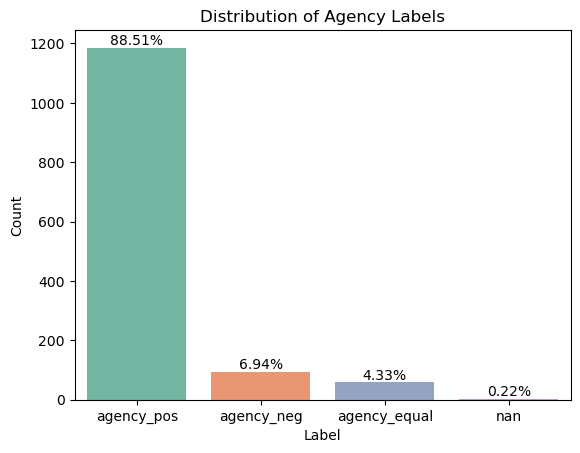

In [206]:
sns.barplot(x=list(agency_counts.keys()), y=list(agency_counts.values()), palette='Set2')
# label bars with percentages
plt.bar_label(plt.gca().containers[0], labels=[f'{p*100:.2f}%' for p in agency_percents])
plt.title('Distribution of Agency Labels')
plt.xlabel('Label')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

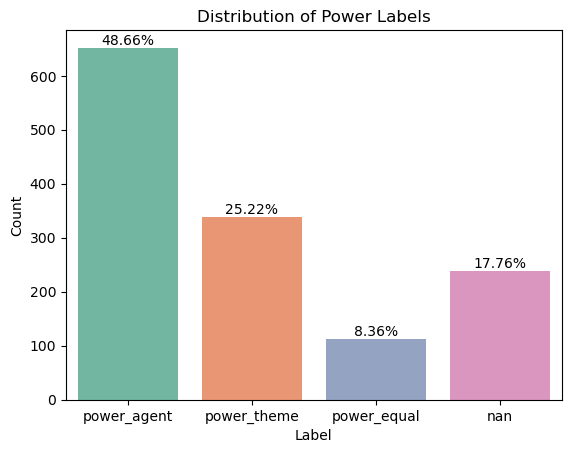

In [207]:
sns.barplot(x=list(power_counts.keys()), y=list(power_counts.values()), palette='Set2')
plt.bar_label(plt.gca().containers[0], labels=[f'{p*100:.2f}%' for p in power_percents])
plt.title('Distribution of Power Labels')
plt.xlabel('Label')
plt.ylabel('Count')

Hand Label Verbs that ChatGPT messed up

In [273]:
len(unlabelled)

17

In [249]:
modified_gpt_preds = gpt_preds.copy()

In [251]:
modified_gpt_preds['v*mited'] = {'agency': 'agency_neg', 'power': 'nan'}
modified_gpt_preds['f*sting'] = {'agency': 'agency_pos', 'power': 'nan'}
modified_gpt_preds['f*ck'] = {'agency': 'agency_pos', 'power': 'power_agent'}
modified_gpt_preds['fvcking'] = {'agency': 'agency_pos', 'power': 'power_agent'}
modified_gpt_preds['fck'] = {'agency': 'agency_pos', 'power': 'power_agent'}
modified_gpt_preds['fuckin'] = {'agency': 'agency_pos', 'power': 'power_agent'}
modified_gpt_preds['fuckign'] = {'agency': 'agency_pos', 'power': 'power_agent'}
modified_gpt_preds['sais'] = {'agency': 'agency_pos', 'power': 'power_equal'}
modified_gpt_preds['goin'] = {'agency': 'nan', 'power': 'power_equal'}
modified_gpt_preds['waisting'] = {'agency': 'agency_equal', 'power': 'power_agent'}
modified_gpt_preds['gained.!&lt'] = {'agency': 'agency_pos', 'power': 'power_agent'}

In [277]:
len(set(missing_verbs))

1358

In [269]:
len(modified_gpt_preds)

1352

In [256]:
final_lexicon = lexicon.copy()
final_lexicon.update(modified_gpt_preds)

In [257]:
len(final_lexicon)

3327

In [261]:
final_lexicon_df = pd.DataFrame(final_lexicon).T

In [264]:
final_lexicon_df

,agency,power
abandon,agency_pos,power_agent
abolish,agency_pos,power_agent
absorb,agency_pos,power_agent
abuse,agency_pos,power_agent
accelerate,agency_pos,power_agent
...,...,...
fuckign,agency_pos,power_agent
sais,agency_pos,power_equal
goin,nan,power_equal
waisting,agency_equal,power_agent


In [263]:
final_lexicon_df.to_csv('data/final_lexicon.csv')